# Simple: get IBOV tickers and print a few

Run the code cell below. It imports `obter_tickers_yfinance` from `data/data.py`, tries to scrape, and falls back to two example tickers if scraping fails.

In [15]:
import yfinance as yf 
import sys
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Ensure repository root is on sys.path if notebook is inside 'notebooks/'
repo_root = Path.cwd()
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from data.data import obter_tickers_yfinance

# Use the function
tickers = obter_tickers_yfinance()


In [17]:
dados = yf.download(tickers, period="10y")
df = dados.stack(level=1)
df = df.reset_index().rename(columns={'level_1': 'Ticker'}) 


/tmp/ipykernel_6462/1365228440.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers, period="10y")
[*********************100%***********************]  82 of 82 completed

1 Failed download:
['PETR3.SA']: Timeout('Failed to perform, curl: (28) Operation timed out after 10000 milliseconds with 35643 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
/tmp/ipykernel_6462/1365228440.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = dados.stack(level=1)


In [18]:
df = df[df['Ticker'] == 'ABEV3.SA'].reset_index(drop=True)

df = df[['Date', 'Close']]

df

Price,Date,Close
0,2015-12-07,12.541657
1,2015-12-08,12.231487
2,2015-12-09,12.460741
3,2015-12-10,12.339371
4,2015-12-11,12.325886
...,...,...
2487,2025-12-01,14.010000
2488,2025-12-02,14.000000
2489,2025-12-03,14.150000
2490,2025-12-04,13.950000


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

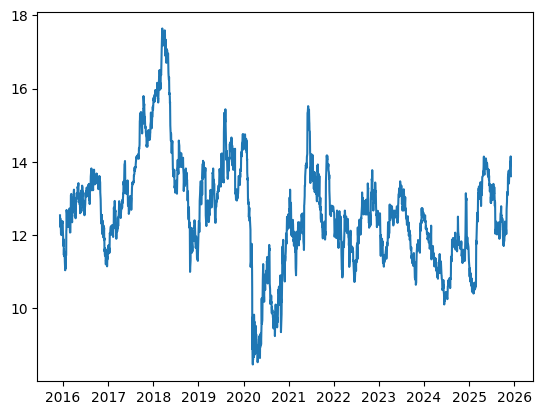

In [20]:
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df['Close'])

In [21]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = df.copy()

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df = shifted_df.to_numpy()
shifted_df

array([[12.23148727, 12.03594398, 12.17079735, ..., 12.46074104,
        12.23148727, 12.54165745],
       [12.23822498, 12.23148727, 12.03594398, ..., 12.33937073,
        12.46074104, 12.23148727],
       [12.00222588, 12.23822498, 12.23148727, ..., 12.32588577,
        12.33937073, 12.46074104],
       ...,
       [14.14999962, 14.        , 14.01000023, ..., 13.67000008,
        13.73999977, 13.77000046],
       [13.94999981, 14.14999962, 14.        , ..., 13.72000027,
        13.67000008, 13.73999977],
       [13.60999966, 13.94999981, 14.14999962, ..., 13.85999966,
        13.72000027, 13.67000008]], shape=(2485, 8))

In [23]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df = scaler.fit_transform(shifted_df)
X = shifted_df[:, 1:]
y = shifted_df[:, 0]

X.shape, y.shape

((2485, 7), (2485,))